In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import timeit
import scipy.stats as st
from joblib import Parallel, delayed
import scipy.stats as stats

### (1) Considering dynamic or % of starting stock

In [2]:
summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785],
    'Annual demand': [28670, 237370, 51831, 13056]
}

In [8]:
import numpy as np
import pandas as pd
import operator
import timeit

start = timeit.default_timer()

class Product:
    def __init__(self, i):
        """
        :type i: int - Product number
        """
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.demand_lead = summary['Expected Demand (Lead Time)'][i - 1]

        mean_demand = summary['Mean Demand (Lead Time)'][i - 1]
        std_dev_demand = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.mean = np.log(mean_demand) if mean_demand > 0 else 0
        self.sd = np.log(std_dev_demand) if std_dev_demand > 0 else 0


def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(product, q, r):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability

    order_placed = False
    order_time = 0
    stock_out = 0

    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}


    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if inventory <= r and not order_placed:
            order_placed = True
            order_time = day

        if order_placed and (day-order_time) == lead_time:
            data['orders'].append(q)
            inventory += q
            order_placed = False
            order_time = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def simulation(product, q, r, num_simulations = 50):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = MCS(product, q, r)

        profit = profit_calculation(data, product)
        profit_list.append(profit)

        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list


def ContinuousReview(product, q_guess, r_guess):
    q_low = q_guess - 1000
    q_high = q_guess + 1000
    q_range = [i for i in range(int(q_low), int(q_high), 10)]

    r_low = r_guess - 300
    r_high = r_guess + 300
    r_range = [i for i in range(int(r_low), int(r_high), 10)]

    review_dict = {}

    for q in q_range:
        for r in r_range:
            p_list, o_list = simulation(product, q, r)
            review_dict[(q, r)] = (
                np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation']

low_percent = 0.8   # 80% of starting stock
high_percent = 1.5  # 150% of starting stock

starting_stock_1 = summary['Starting Stock'][0]
starting_stock_2 = summary['Starting Stock'][1]
starting_stock_3 = summary['Starting Stock'][2]
starting_stock_4 = summary['Starting Stock'][3]

low = int(starting_stock_1 * low_percent)
high = int(starting_stock_1 * high_percent)

review = ContinuousReview(Product(1), low, high)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_2 * low_percent)
high = int(starting_stock_2 * high_percent)

review = ContinuousReview(Product(2), low, high)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_3 * low_percent)
high = int(starting_stock_3 * high_percent)

review = ContinuousReview(Product(3), low, high)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

low = int(starting_stock_4 * low_percent)
high = int(starting_stock_4 * high_percent)

review = ContinuousReview(Product(4), low, high)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

df_product_review = pd.DataFrame(
    {'1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][3]],
     '2': [prod_review_2[0], prod_review_2[1][0], prod_review_2[1][3]],
     '3': [prod_review_3[0], prod_review_3[1][0], prod_review_3[1][3]],
     '4': [prod_review_4[0], prod_review_4[1][0], prod_review_4[1][3]]}),
    # index=idx[:-1])

print(df_product_review)

stop = timeit.default_timer()
print('Time: ', stop - start)

(               1               2              3              4
0   (3180, 4095)  (18950, 33940)   (5140, 7710)   (1820, 2370)
1  447626.661205  1633884.813389  504179.237874  688613.935902
2   20366.693421     53635.00908    4608.831815  122741.876355,)
Time:  4693.921483135001


visualize the relationship between the order quantity (q), reorder point (r), and profit based on the simulation results.

These plots help us to understand how changes in q and r affect the expected profit for each product.

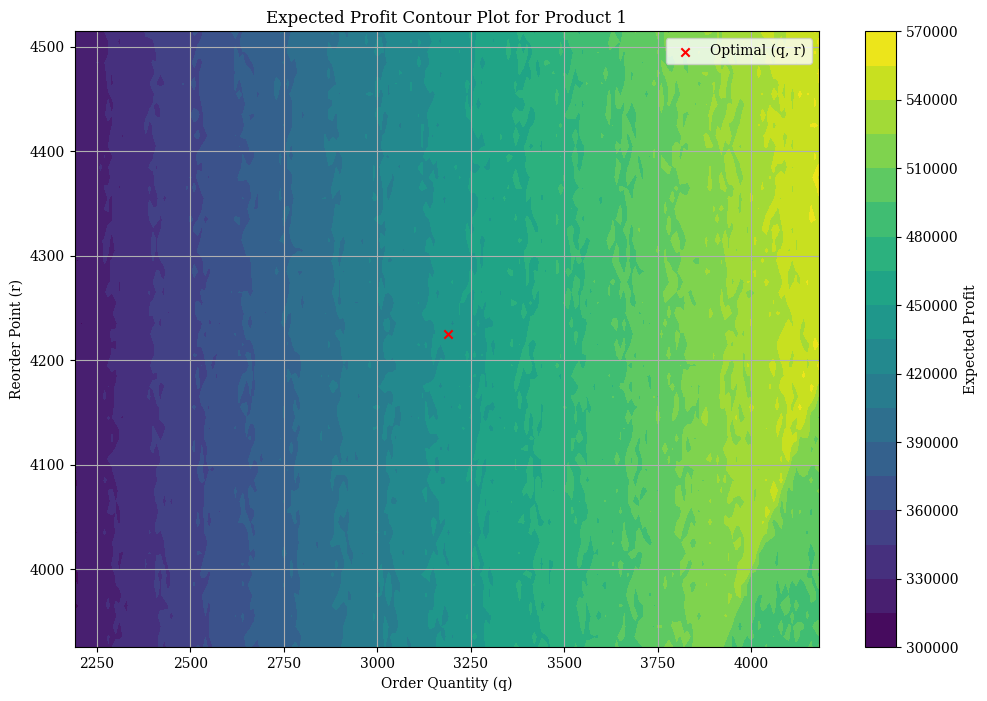

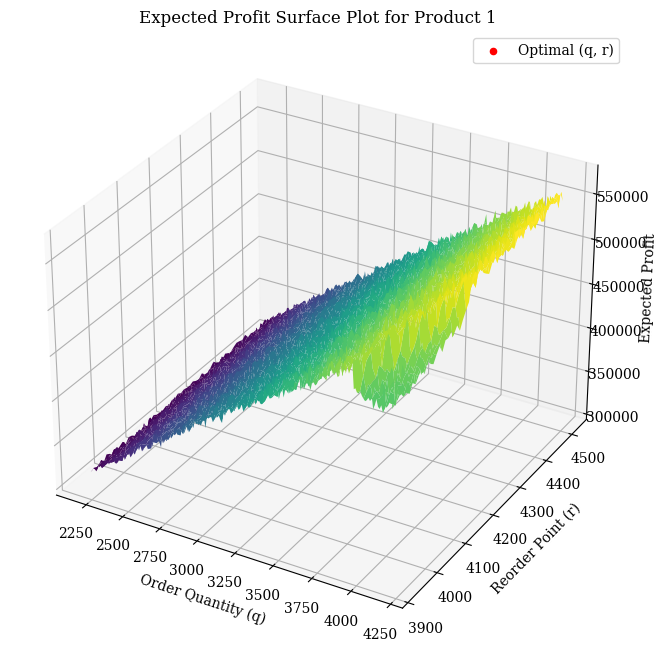

In [10]:
def get_best_qr(product_index, low, high):
    starting_stock = summary['Starting Stock'][product_index]
    low_val = int(starting_stock * low)
    high_val = int(starting_stock * high)
    review = ContinuousReview(Product(product_index + 1), low_val, high_val)
    return max(review.items(), key=operator.itemgetter(1))

prod_review_1 = get_best_qr(0, low_percent, high_percent)
prod_review_2 = get_best_qr(1, low_percent, high_percent)
prod_review_3 = get_best_qr(2, low_percent, high_percent)
prod_review_4 = get_best_qr(3, low_percent, high_percent)

q_values = np.arange(prod_review_1[0][0] - 1000, prod_review_1[0][0] + 1000, 10)
r_values = np.arange(prod_review_1[0][1] - 300, prod_review_1[0][1] + 300, 10)
profit_values = np.zeros((len(q_values), len(r_values)))

for i, q in enumerate(q_values):
    for j, r in enumerate(r_values):
        p_list, _ = simulation(Product(1), q, r)
        profit_values[i, j] = np.mean(p_list)

# contour plot
plt.figure(figsize=(12, 8))
plt.contourf(q_values, r_values, profit_values.T, 20, cmap='viridis')
plt.colorbar(label='Expected Profit')
plt.xlabel('Order Quantity (q)')
plt.ylabel('Reorder Point (r)')
plt.title('Expected Profit Contour Plot for Product 1')
plt.scatter(prod_review_1[0][0], prod_review_1[0][1], marker='x', color='red', label='Optimal (q, r)')
plt.legend()
plt.grid(True)
plt.show()

# 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
Q, R = np.meshgrid(q_values, r_values)
ax.plot_surface(Q, R, profit_values.T, cmap='viridis', edgecolor='none')
ax.set_xlabel('Order Quantity (q)')
ax.set_ylabel('Reorder Point (r)')
ax.set_zlabel('Expected Profit')
ax.set_title('Expected Profit Surface Plot for Product 1')
ax.scatter(prod_review_1[0][0], prod_review_1[0][1], np.mean(prod_review_1[1][:3]), color='red', label='Optimal (q, r)')
ax.legend()
plt.show()

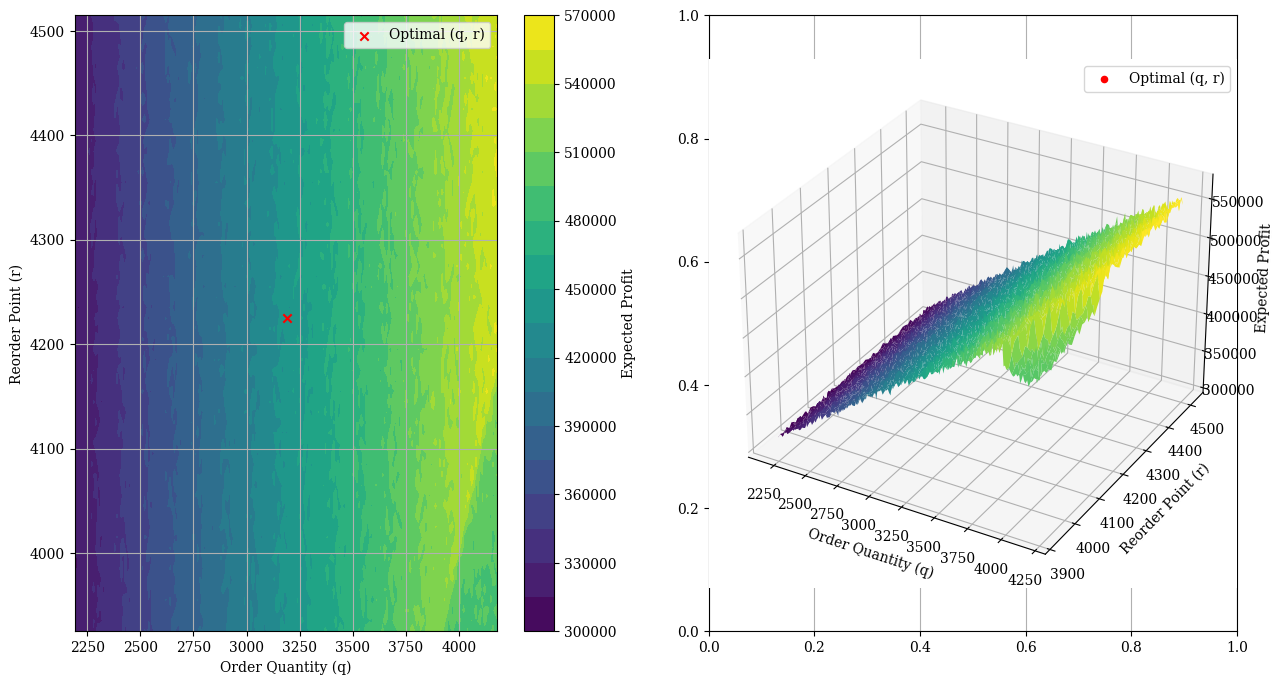

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Contour plot
contour = ax1.contourf(q_values, r_values, profit_values.T, 20, cmap='viridis')
fig.colorbar(contour, ax=ax1, label='Expected Profit')
ax1.set_xlabel('Order Quantity (q)')
ax1.set_ylabel('Reorder Point (r)')
# ax1.set_title('Expected Profit Contour Plot for Product 1')
ax1.scatter(prod_review_1[0][0], prod_review_1[0][1], marker='x', color='red', label='Optimal (q, r)')
ax1.legend()
ax1.grid(True)

# 3D surface plot
ax2 = fig.add_subplot(122, projection='3d')
Q, R = np.meshgrid(q_values, r_values)
ax2.plot_surface(Q, R, profit_values.T, cmap='viridis', edgecolor='none')
ax2.set_xlabel('Order Quantity (q)')
ax2.set_ylabel('Reorder Point (r)')
ax2.set_zlabel('Expected Profit')
# ax2.set_title('Expected Profit Surface Plot for Product 1')
ax2.scatter(prod_review_1[0][0], prod_review_1[0][1], np.mean(prod_review_1[1][:3]), color='red', label='Optimal (q, r)')
ax2.legend()

plt.show()
